# Experiments: Generative Design for Precision Geo-interventions

Richard Wen <rwen@ryerson.ca> and Songnian Li <snli@ryerson.ca>

Experiments for [Gi4DM & Urban Geoinformatices 2022 Conference](https://www.gi4dm.net/2022/).

## Libaries

In [1]:
from pathlib import Path
from pickle import dump, load
from pprint import pprint
from itables import init_notebook_mode

import geointerventions as geoint
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

init_notebook_mode(all_interactive=True)

/usr/local/anaconda3/envs/gi4dm-2022-paper/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<IPython.core.display.Javascript object>

## Train AutoML Models

In [2]:
models = {}
geodata = {}
for size in [10, 40, 80]:
    
    # Load data
    print(f'Processing geogrid_to_{size}...')
    xraw = gpd.read_file(f'../downloads/geogrid_to_{size}.geojson')
    x = pd.DataFrame(xraw.drop(columns='geometry'))
    ycol = 'collisions_count'
    geodata[f'geogrid_to_{size}'] = xraw
    
    # Columns to remove from input data
    startswith = [
        'collisions_pd',
        'collisions_fatalities',
        'collisions_ftr',
        'collisions_injury',
        'collisions_day',
        'collisions_month',
        'collisions_year',
        'collisions_hour',
        'collisions_day',
        'collisions_month'
    ]
    
    # Drop columns except target col
    drop = [c for c in x.columns if any(c.startswith(s) for s in startswith) and c != ycol]
    x = x.drop(columns=drop)
    
    # Train autosklearn model
    ask_file = f'../downloads/autosklearn_{size}.pkl'
    if Path(ask_file).is_file():
        print(f'Model for autosklearn_{size} exists - skipping training...')
        with open(ask_file, 'rb') as f:
            ask = load(f)
    else:
        print(f'Training model for autosklearn_{size}...')
        ask = geoint.models.AutoMLModel('AutoSklearnRegressor')
        ask.fit(x=x, y=ycol)
        ask.predict()
        print(f'Saving model for autosklearn_{size}...')
        with open(ask_file, 'wb') as f:
            dump(ask, f)
    
    # Train tpot model
    tpt_file = f'../downloads/tpot_{size}.pkl'
    if Path(tpt_file).is_file():
        print(f'Model for tpot_{size} exists - skipping training...')
        tpt = geoint.models.AutoMLModel('TPOTRegressor')
        with open(tpt_file, 'rb') as f:
            tpt.model = load(f)
        tpt.last_x = x.drop(columns=ycol).select_dtypes('number').fillna(0)
        tpt.last_y = x[ycol]
        tpt.predict()
    else:
        print(f'Training model for tpot_{size}...')
        tpt = geoint.models.AutoMLModel('TPOTRegressor')
        tpt.fit(x=x, y=ycol)
        tpt.predict()
        print(f'Saving model for tpot_{size}...')
        with open(tpt_file, 'wb') as f:
            dump(tpt.model.fitted_pipeline_, f)
    
    # Store models
    models[f'autosklearn_{size}'] = ask
    models[f'tpot_{size}'] = tpt

print('Done!')

Processing geogrid_to_10...
Model for autosklearn_10 exists - skipping training...
Model for tpot_10 exists - skipping training...
Processing geogrid_to_40...
Model for autosklearn_40 exists - skipping training...
Model for tpot_40 exists - skipping training...
Processing geogrid_to_80...
Model for autosklearn_80 exists - skipping training...
Model for tpot_80 exists - skipping training...
Done!


Preview models:

In [3]:
pprint(models)

{'autosklearn_10': <geointerventions.models.AutoMLModel object at 0x105726610>,
 'autosklearn_40': <geointerventions.models.AutoMLModel object at 0x149477ca0>,
 'autosklearn_80': <geointerventions.models.AutoMLModel object at 0x14946a640>,
 'tpot_10': <geointerventions.models.AutoMLModel object at 0x105613c10>,
 'tpot_40': <geointerventions.models.AutoMLModel object at 0x149477dc0>,
 'tpot_80': <geointerventions.models.AutoMLModel object at 0x15180b040>}


## Calculate Model Scores

In [4]:
scores = {'model': [], 'metric': [], 'score': []}
for name, m in models.items():
    
    # Default score
    scores['model'].append(name)
    scores['score'].append(m.score())
    scores['metric'].append(m.last_metric)
    
    # MAE score
    scores['model'].append(name)
    scores['score'].append(m.score(metric='mean_absolute_error'))
    scores['metric'].append('mean_absolute_error')
scores = pd.DataFrame(scores)

Preview scores:

In [5]:
scores

model               metric         score
0   autosklearn_10             r2_score  9.876858e-01
1   autosklearn_10  mean_absolute_error  4.926774e+02
2          tpot_10             r2_score  9.732950e-01
3          tpot_10  mean_absolute_error  6.300823e+02
4   autosklearn_40             r2_score -2.220446e-16
5   autosklearn_40  mean_absolute_error  4.064582e+02
6          tpot_40             r2_score -9.005019e-02
7          tpot_40  mean_absolute_error  3.022918e+02
8   autosklearn_80             r2_score  0.000000e+00
9   autosklearn_80  mean_absolute_error  1.176839e+02
10         tpot_80             r2_score -4.024411e+00
11         tpot_80  mean_absolute_error  3.664358e+02

<AxesSubplot: title={'center': 'R^2 Score'}, xlabel='model'>

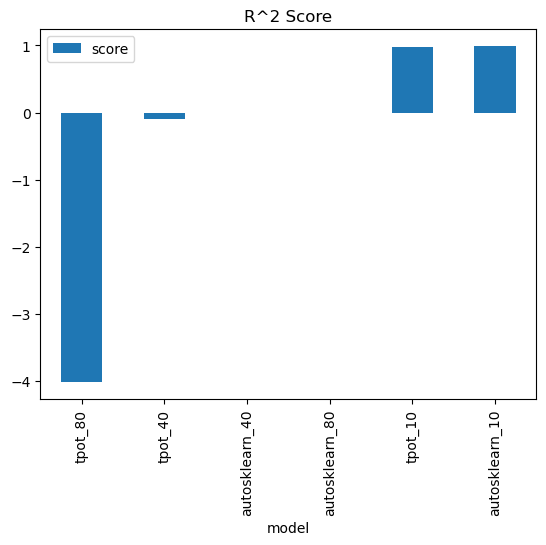

In [6]:
scores[scores.metric == 'r2_score'].sort_values(by='score').plot.bar(x='model', y='score', title='R^2 Score')

<AxesSubplot: title={'center': 'Mean Absolute Error (MAE)'}, xlabel='Model'>

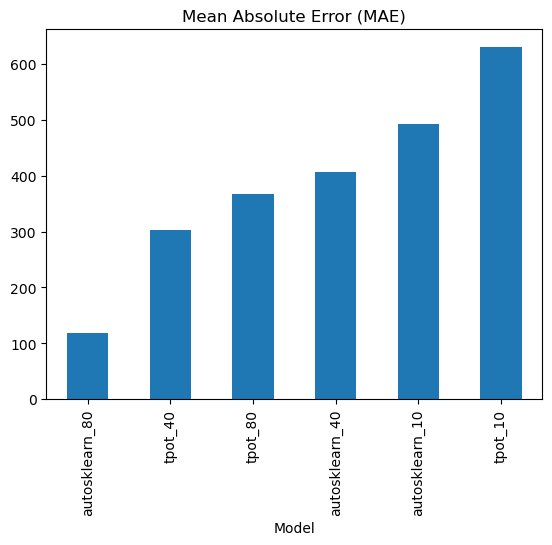

In [7]:
scores[scores.metric == 'mean_absolute_error'].sort_values(by='score').plot.bar(x='model', y='score', xlabel='Model', legend=False, title='Mean Absolute Error (MAE)')

## Calculate Variable Importances

In [8]:
importances = []
for name, m in models.items():
    print(f'Processing {name}...')
    imp_file = f'../downloads/{name}_importance.pkl'
    
    # Calculate var importances
    if Path(imp_file).is_file():
        print(f'Variable importances for {name} exists - loading...')
        with open(imp_file, 'rb') as f:
            imp = load(f) 
    else:
        print(f'Calculating variable importances for {name}...')
        imp = m.importance()
        with open(imp_file, 'wb') as f:
            dump(imp, f)
    
    # Store var importances
    imp['model'] = name
    importances.append(imp)

# Combine importances
importances = pd.concat(importances).sort_values(by='importance_mean', ascending=False)
print('Done!')

Processing autosklearn_10...
Variable importances for autosklearn_10 exists - loading...
Processing tpot_10...
Variable importances for tpot_10 exists - loading...
Processing autosklearn_40...
Variable importances for autosklearn_40 exists - loading...
Processing tpot_40...
Variable importances for tpot_40 exists - loading...
Processing autosklearn_80...
Variable importances for autosklearn_80 exists - loading...
Processing tpot_80...
Variable importances for tpot_80 exists - loading...
Done!


Preview importances:

In [9]:
importances

variable  importance_mean  \
1389                            traffic_count     1.192115e+07   
181                             schools_count     2.840876e+06   
171                              litter_count     2.122465e+06   
691                      red_light_cams_count     2.054922e+06   
1                      transit_shelters_count     1.243445e+06   
...                                       ...              ...   
366   crime_reporteddayofweek_wednesday_count    -4.291936e+03   
416             crime_occurrencehour_14_count    -5.143822e+03   
696                     traffic_sb_cars_r_max    -5.214817e+03   
927                    traffic_wb_truck_r_sum    -1.548245e+04   
1201                     traffic_wx_peds_mean    -1.602278e+04   

      importance_std    model  
1389   840252.798823  tpot_10  
181    197078.123488  tpot_10  
171    177988.282097  tpot_10  
691    201398.455126  tpot_10  
1      108740.042669  tpot_10  
...              ...      ...  
366      1108.298534  tpot_80  
416       367.915273  tpot_80  
696      1335.109243  tpot_80  
927       788.494211  tpot_80  
1201      716.726791  tpot_80  

[8340 rows x 4 columns]

<AxesSubplot: title={'center': 'Variable Importance'}, ylabel='Variable'>

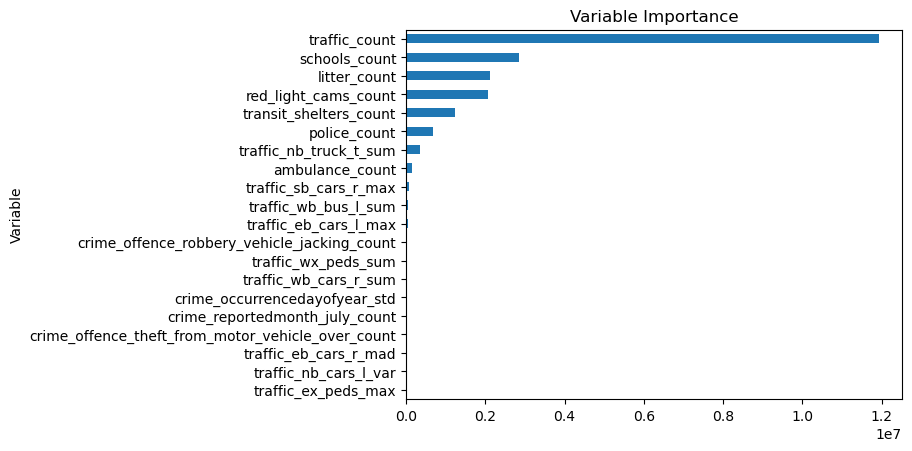

In [10]:
importances\
    .nlargest(20, 'importance_mean')\
    .sort_values(by='importance_mean')\
    .plot.barh(x='variable', y='importance_mean', xlabel='Variable', title='Variable Importance', legend=False)

<AxesSubplot: title={'center': 'Variable Importance'}, ylabel='Variable'>

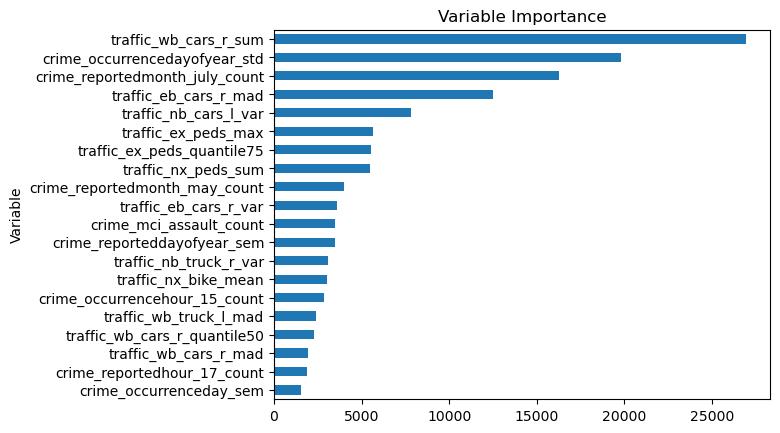

In [11]:
importances[importances.model == 'tpot_80']\
    .nlargest(20, 'importance_mean')\
    .sort_values(by='importance_mean')\
    .plot.barh(x='variable', y='importance_mean', xlabel='Variable', title='Variable Importance', legend=False)

## Optimization

In [12]:
opt_results = {
    'scenario': [],
    'original': [],
    'optimized': [],
    'model': []
}

opt_model = 'autosklearn_80'

### Scenario 1

Create geo-interventions by optimizing transit shelters, red light cameras, schools, and watch your speed program signs in grid cells with higher than average westbound car traffic.

In [13]:
# Define local constraints
lconstr1 = {
    'transit_shelters_count': {'query': 'traffic_wb_cars_r_sum >= traffic_wb_cars_r_sum.mean()'},
    'red_light_cams_count': {'query': 'traffic_wb_cars_r_sum >= traffic_wb_cars_r_sum.mean()'},
    'schools_count': {'query': 'traffic_wb_cars_r_sum >= traffic_wb_cars_r_sum.mean()'},
    'wys_count': {'query': 'traffic_wb_cars_r_sum >= traffic_wb_cars_r_sum.mean()'}
}

# Create optimizer
print(f'Optimizing predictions for {opt_model}...')
opt1_file = f'../downloads/{opt_model}_opt1.pkl'
if Path(opt1_file).is_file():
    
    # Load optimizer from saved file
    print(f'Optimizer for {opt_model} exists - loading results...')
    with open(opt1_file, 'rb') as f:
        opt1_results = load(f)
else:
    
    # Run optimizer
    print(f'Running optimization for {opt_model}...')
    opt1 = geoint.optimization.Optimizer(models[opt_model], lconstr1, 'BayesianOptimization', verbose=0, ymax=False)
    opt1.optimize(n_iter=10)
    
    # Save results
    print(f'Saving optimization for {opt_model}...')
    opt1_results = {
        'original': [sum(opt1.model.last_y)],
        'optimized': [opt1.optimal_y],
        'optimal': opt1.optimal,
        'optimal_params': opt1.optimal_params,
        'optimal_details': opt1.optimal_details,
        'params': opt1.optimizer_params
    }
    with open(opt1_file, 'wb') as f:
        dump(opt1_results, f)
        
# Store opt results
opt_results['scenario'] += ['Scenario 1: Higher than avg westbound car traffic']
opt_results['original'] += opt1_results['original']
opt_results['optimized'] += opt1_results['optimized']
opt_results['model'] += [opt_model]
print('Done!')

Optimizing predictions for autosklearn_80...
Optimizer for autosklearn_80 exists - loading results...
Done!


In [14]:
opt1_results

{'original': [429630.0],
 'optimized': [227108.61246490479],
 'optimal': {'target': -227108.61246490479,
  'params': {'red_light_cams_count_1004': 1.6505218694617896,
   'red_light_cams_count_1008': 0.7392956064724747,
   'red_light_cams_count_1016': 0.018829188719251544,
   'red_light_cams_count_1048': 3.3546493076334247,
   'red_light_cams_count_1062': 3.5438270694433243,
   'red_light_cams_count_1063': 2.0704429586729307,
   'red_light_cams_count_1064': 1.9650500835911058,
   'red_light_cams_count_1069': 3.9083134715278076,
   'red_light_cams_count_1073': 0.37364328555120174,
   'red_light_cams_count_1106': 0.9820392090915826,
   'red_light_cams_count_1108': 0.8207904710463123,
   'red_light_cams_count_1112': 1.864906244193259,
   'red_light_cams_count_1113': 3.9761917996469305,
   'red_light_cams_count_1119': 1.1562934070094513,
   'red_light_cams_count_1122': 2.5201899607949505,
   'red_light_cams_count_1126': 2.3559350423078715,
   'red_light_cams_count_1130': 1.7617454401294679,

### Scenario 2

Create geo-interventions by optimizing transit shelters, red light cameras, schools, and watch your speed program signs in grid cells with lower than average transit shelters, red light cameras, schools, and watch your speed program signs respectively.

In [15]:
# Define local constraints
lconstr2 = {
    'transit_shelters_count': {'query': 'transit_shelters_count < transit_shelters_count.mean()'},
    'red_light_cams_count': {'query': 'red_light_cams_count < red_light_cams_count.mean()'},
    'schools_count': {'query': 'schools_count < schools_count.mean()'},
    'wys_count': {'query': 'wys_count < wys_count.mean()'}
}

# Create optimizer
print(f'Optimizing predictions for {opt_model}...')
opt2_file = f'../downloads/{opt_model}_opt2.pkl'
if Path(opt2_file).is_file():
    
    # Load optimizer from saved file
    print(f'Optimizer for {opt_model} exists - loading results...')
    with open(opt2_file, 'rb') as f:
        opt2_results = load(f)
else:
    
    # Run optimizer
    print(f'Running optimization for {opt_model}...')
    opt2 = geoint.optimization.Optimizer(models[opt_model], lconstr2, 'BayesianOptimization', verbose=0, ymax=False)
    opt2.optimize(n_iter=10)
    
    # Save results
    print(f'Saving optimization for {opt_model}...')
    opt2_results = {
        'original': [sum(opt2.model.last_y)],
        'optimized': [opt2.optimal_y],
        'optimal': opt2.optimal,
        'optimal_params': opt2.optimal_params,
        'optimal_details': opt2.optimal_details,
        'params': opt2.optimizer_params
    }
    with open(opt2_file, 'wb') as f:
        dump(opt2_results, f)
        
# Store opt results
opt_results['scenario'] += ['Scenario 2: Modify scarce intervention cells']
opt_results['original'] += opt2_results['original']
opt_results['optimized'] += opt2_results['optimized']
opt_results['model'] += [opt_model]
print('Done!')

Optimizing predictions for autosklearn_80...
Optimizer for autosklearn_80 exists - loading results...
Done!


In [16]:
opt2_results

{'original': [429630.0],
 'optimized': [435757.04067230225],
 'optimal': {'target': -435757.04067230225,
  'params': {'red_light_cams_count_0': 1.7028374971549,
   'red_light_cams_count_1': 2.008053823484441,
   'red_light_cams_count_10': 1.7180419532914528,
   'red_light_cams_count_100': 0.18154680521271827,
   'red_light_cams_count_1000': 2.3471793028820134,
   'red_light_cams_count_1001': 2.3957989892113467,
   'red_light_cams_count_1002': 3.7453969605899973,
   'red_light_cams_count_1003': 2.40336145412514,
   'red_light_cams_count_1004': 3.1037044818802872,
   'red_light_cams_count_1005': 2.589317228138122,
   'red_light_cams_count_1006': 2.481849560170266,
   'red_light_cams_count_1007': 1.8244745771109963,
   'red_light_cams_count_1008': 3.8128830438461123,
   'red_light_cams_count_1009': 0.09755764344529361,
   'red_light_cams_count_101': 3.4424604972888413,
   'red_light_cams_count_1010': 0.19998140077915405,
   'red_light_cams_count_1011': 1.955068112525383,
   'red_light_cam

### Optimization Results

In [17]:
opt_results = pd.DataFrame(opt_results)
opt_results['diff'] = opt_results.optimized - opt_results.original
opt_results

scenario  original      optimized  \
0  Scenario 1: Higher than avg westbound car traffic  429630.0  227108.612465   
1       Scenario 2: Modify scarce intervention cells  429630.0  435757.040672   

            model           diff  
0  autosklearn_80 -202521.387535  
1  autosklearn_80    6127.040672

## Generated Geo-interventions

In [18]:
# Read data for selected model
gdata = geodata['geogrid_to_80'].copy()
gcols = [
    'transit_shelters_count',
    'red_light_cams_count',
    'schools_count',
    'wys_count'
]

# Get optimal parameters
optimalp = {
    'opt1': opt1_results['optimal_params'],
    'opt2': opt2_results['optimal_params'],
}

# Get params used for optimization
opt_params = {
    'opt1': opt1_results['params'],
    'opt2': opt2_results['params']
}
for k in opt_params:
    opt_params[k].index.name = None
    
# Set params to optimal params
for k in opt_params:
    opt_params[k]['value_optimal'] = opt_params[k]['value_orig']
    opt_params[k].loc[optimalp[k].keys(), 'value_optimal'] = list(optimalp[k].values())

In [19]:
# Set data to optimal params
for k in opt_params:
    params = opt_params[k]
    for c in params.column.unique():
        p = params[params.column == c]
        oc = f'{c}_{k}'
        gdata[oc] = gdata[c].copy()
        gdata.loc[p.row, oc] = p.value_optimal.tolist()
        gdata[f'{oc}_diff'] = gdata[oc] - gdata[c]

In [20]:
gdata[[c + '_opt1' for c in gcols] + [ycol]]

transit_shelters_count_opt1  red_light_cams_count_opt1  \
0                             0.0                        0.0   
1                             0.0                        0.0   
2                             0.0                        0.0   
3                             0.0                        0.0   
4                             0.0                        0.0   
...                           ...                        ...   
4997                          0.0                        0.0   
4998                          0.0                        0.0   
4999                          0.0                        0.0   
5000                          0.0                        0.0   
5001                          0.0                        0.0   

      schools_count_opt1  wys_count_opt1  collisions_count  
0                    0.0             0.0               0.0  
1                    0.0             0.0               0.0  
2                    0.0             0.0               0.0  
3                    0.0             0.0               0.0  
4                    0.0             0.0               0.0  
...                  ...             ...               ...  
4997                 0.0             0.0               0.0  
4998                 0.0             0.0               0.0  
4999                 0.0             0.0               0.0  
5000                 0.0             0.0               0.0  
5001                 0.0             0.0               0.0  

[5002 rows x 5 columns]

### Optimization Parameters

In [21]:
opt_params['opt1']

column   row  \
transit_shelters_count_280  transit_shelters_count   280   
transit_shelters_count_334  transit_shelters_count   334   
transit_shelters_count_339  transit_shelters_count   339   
transit_shelters_count_397  transit_shelters_count   397   
transit_shelters_count_403  transit_shelters_count   403   
...                                            ...   ...   
wys_count_4500                           wys_count  4500   
wys_count_4560                           wys_count  4560   
wys_count_4621                           wys_count  4621   
wys_count_4682                           wys_count  4682   
wys_count_4683                           wys_count  4683   

                                                 param      value  \
transit_shelters_count_280  transit_shelters_count_280   1.654842   
transit_shelters_count_334  transit_shelters_count_334  13.637271   
transit_shelters_count_339  transit_shelters_count_339  25.022266   
transit_shelters_count_397  transit_shelters_count_397  11.030132   
transit_shelters_count_403  transit_shelters_count_403  12.757939   
...                                                ...        ...   
wys_count_4500                          wys_count_4500   7.789794   
wys_count_4560                          wys_count_4560   6.949292   
wys_count_4621                          wys_count_4621   5.393571   
wys_count_4682                          wys_count_4682   3.765117   
wys_count_4683                          wys_count_4683   0.262364   

                                 bounds  value_orig  value_optimal  
transit_shelters_count_280  (0.0, 27.0)         3.0       6.229441  
transit_shelters_count_334  (0.0, 27.0)         2.0      26.083892  
transit_shelters_count_339  (0.0, 27.0)         3.0      11.901917  
transit_shelters_count_397  (0.0, 27.0)         4.0       3.345462  
transit_shelters_count_403  (0.0, 27.0)         3.0      11.700441  
...                                 ...         ...            ...  
wys_count_4500              (0.0, 19.0)         0.0       7.372653  
wys_count_4560              (0.0, 19.0)         0.0       0.356126  
wys_count_4621              (0.0, 19.0)         0.0       9.071945  
wys_count_4682              (0.0, 19.0)         0.0      10.414621  
wys_count_4683              (0.0, 19.0)         0.0       9.429102  

[1860 rows x 7 columns]

In [22]:
len(opt_params['opt1'].index)

1860

In [23]:
opt_params['opt2']

column   row  \
transit_shelters_count_0  transit_shelters_count     0   
transit_shelters_count_1  transit_shelters_count     1   
transit_shelters_count_2  transit_shelters_count     2   
transit_shelters_count_3  transit_shelters_count     3   
transit_shelters_count_4  transit_shelters_count     4   
...                                          ...   ...   
wys_count_4997                         wys_count  4997   
wys_count_4998                         wys_count  4998   
wys_count_4999                         wys_count  4999   
wys_count_5000                         wys_count  5000   
wys_count_5001                         wys_count  5001   

                                             param      value       bounds  \
transit_shelters_count_0  transit_shelters_count_0  19.036033  (0.0, 27.0)   
transit_shelters_count_1  transit_shelters_count_1   8.106165  (0.0, 27.0)   
transit_shelters_count_2  transit_shelters_count_2   3.825028  (0.0, 27.0)   
transit_shelters_count_3  transit_shelters_count_3   7.493578  (0.0, 27.0)   
transit_shelters_count_4  transit_shelters_count_4   7.484897  (0.0, 27.0)   
...                                            ...        ...          ...   
wys_count_4997                      wys_count_4997  15.126619  (0.0, 19.0)   
wys_count_4998                      wys_count_4998  11.237957  (0.0, 19.0)   
wys_count_4999                      wys_count_4999   9.945520  (0.0, 19.0)   
wys_count_5000                      wys_count_5000  16.348689  (0.0, 19.0)   
wys_count_5001                      wys_count_5001   0.201524  (0.0, 19.0)   

                          value_orig  value_optimal  
transit_shelters_count_0         0.0       1.365668  
transit_shelters_count_1         0.0      22.722096  
transit_shelters_count_2         0.0      18.059557  
transit_shelters_count_3         0.0      12.428223  
transit_shelters_count_4         0.0       4.507813  
...                              ...            ...  
wys_count_4997                   0.0       6.762570  
wys_count_4998                   0.0      17.670378  
wys_count_4999                   0.0       5.258621  
wys_count_5000                   0.0      10.847733  
wys_count_5001                   0.0      18.678386  

[17328 rows x 7 columns]

In [24]:
len(opt_params['opt2'].index)

17328

### Geo-intervention Maps

Scenario 1

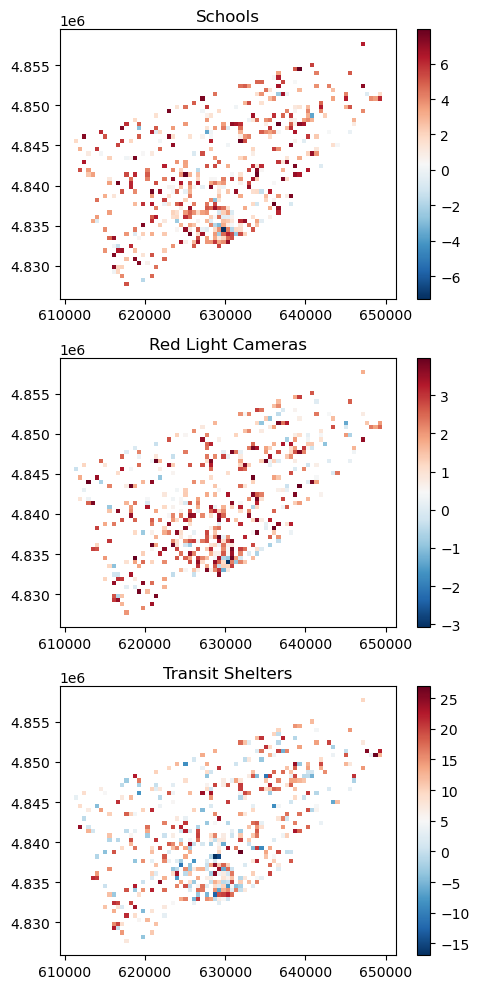

In [48]:
fig = plt.figure()
fig.set_size_inches(5, 10)
pdata = gdata.copy()
pdata.replace(0, np.nan, inplace=True)

# Red light cams
ax = plt.subplot(3, 1, 1) # nrows, ncols, axes position
pdata.plot(ax=ax, cmap='RdBu_r', column='schools_count_opt1_diff', legend=True)
ax.set_title('Schools')
ax.set_aspect('equal', adjustable='datalim')

# Red light cams
ax = plt.subplot(3, 1, 2) # nrows, ncols, axes position
pdata.plot(ax=ax, cmap='RdBu_r', column='red_light_cams_count_opt1_diff', legend=True)
ax.set_title('Red Light Cameras')
ax.set_aspect('equal', adjustable='datalim')

# Transit shelters
ax = plt.subplot(3, 1, 3) # nrows, ncols, axes position
pdata.plot(ax=ax, cmap='RdBu_r', column='transit_shelters_count_opt1_diff', legend=True)
ax.set_title('Transit Shelters')
ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()
plt.show()

Scenario 2

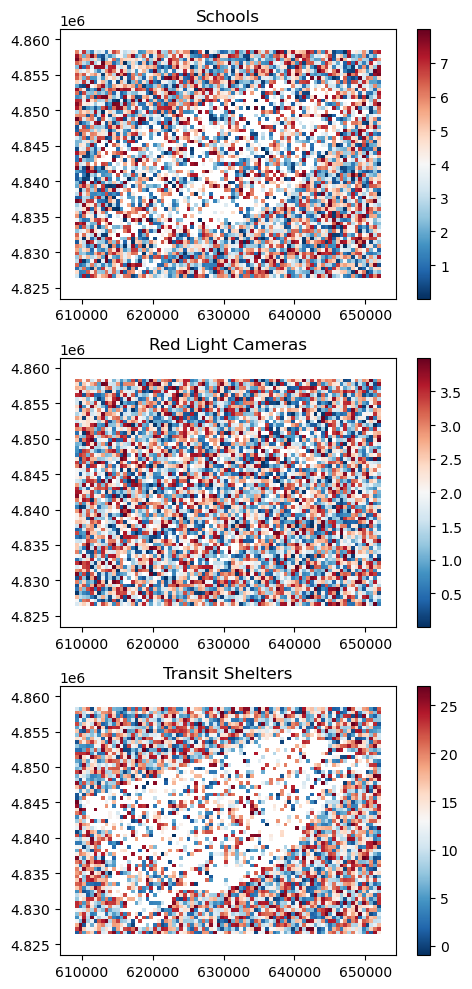

In [49]:
fig = plt.figure()
fig.set_size_inches(5, 10)
pdata = gdata.copy()
pdata.replace(0, np.nan, inplace=True)

# Red light cams
ax = plt.subplot(3, 1, 1) # nrows, ncols, axes position
pdata.plot(ax=ax, cmap='RdBu_r', column='schools_count_opt2_diff', legend=True)
ax.set_title('Schools')
ax.set_aspect('equal', adjustable='datalim')

# Red light cams
ax = plt.subplot(3, 1, 2) # nrows, ncols, axes position
pdata.plot(ax=ax, cmap='RdBu_r', column='red_light_cams_count_opt2_diff', legend=True)
ax.set_title('Red Light Cameras')
ax.set_aspect('equal', adjustable='datalim')

# Transit shelters
ax = plt.subplot(3, 1, 3) # nrows, ncols, axes position
pdata.plot(ax=ax, cmap='RdBu_r', column='transit_shelters_count_opt2_diff', legend=True)
ax.set_title('Transit Shelters')
ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()
plt.show()